In [50]:
from python_files.open_fits_file import openfits
path_to_data = 'C:/Users/andre/MasterCode/Grizli_transient_data/obs18'
names, Data, Header= openfits(path_to_data)

In [51]:
#        old      new      diff     150      200      277     356       444
data = [Data[2], Data[1], Data[0], Data[3], Data[4], Data[5], Data[6], Data[7]]
header = [Header[2], Header[1], Header[0], Header[3], Header[4], Header[5], Header[6], Header[7]]

In [52]:
import numpy as np
import matplotlib.pyplot as plt
def plot_image(Data, ep=1):
    file = Data
    mean = np.mean(file)
    std = np.std(file)
    plt.imshow(file, vmin=mean-ep*std, vmax=mean+ep*std)

In [53]:
#Confirmation that 0 = old, 2 = diff
# plt.figure(figsize=(16,8))
# plt.subplot(1, 3, 1)
# plot_image(data[0][5000:10000,5000:10000])
# plt.subplot(1, 3, 2)
# plot_image(data[1][5000:10000,5000:10000])
# plt.subplot(1, 3, 3)
# plot_image(data[2][5000:10000,5000:10000])


In [54]:
import csv

# Open the CSV file
#path_to_CNN_predictions = 'C:/Users/andre/MasterCode/Code/Predicted_transients/Predicted_transients_'+path_to_data[-5:]+'.csv'
path_to_CNN_predictions = 'C:/Users/andre/MasterCode/Code/Predicted_transients/All_transformations_'+path_to_data[-5:]+'.csv'
with open(path_to_CNN_predictions, mode='r') as file:
    transients = []
    non_transients = []
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    # Iterate through each row in the CSV file
    for row in csv_reader:
        if row[3] == '1.0':
            transients.append(row)
        if row[3] == '0.0':
            non_transients.append(row)
            #print(row)  # Each row is a list of strings

In [55]:
import csv

# Open the CSV file
path_to_CNN_predictions = 'C:/Users/andre/MasterCode/Code/Predicted_transients/Predicted_transients_obs17.csv'
with open(path_to_CNN_predictions, mode='r') as file:
    transients_obs17 = []
    non_transients_obs17 = []
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    # Iterate through each row in the CSV file
    for row in csv_reader:
        if row[3] == '1.0':
            transients_obs17.append(row)
        if row[3] == '0.0':
            non_transients_obs17.append(row)
            #print(row)  # Each row is a list of strings

path_to_CNN_predictions = 'C:/Users/andre/MasterCode/Code/Predicted_transients/Predicted_transients_obs18.csv'
with open(path_to_CNN_predictions, mode='r') as file:
    transients_obs18 = []
    non_transients_obs18 = []
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    # Iterate through each row in the CSV file
    for row in csv_reader:
        if row[3] == '1.0':
            transients_obs18.append(row)
        if row[3] == '0.0':
            non_transients_obs18.append(row)
            #print(row)  # Each row is a list of strings

path_to_CNN_predictions = 'C:/Users/andre/MasterCode/Code/Predicted_transients/All_transformations_obs17.csv'
with open(path_to_CNN_predictions, mode='r') as file:
    transients_all_trans_obs17 = []
    non_transients_all_trans_obs17 = []
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    # Iterate through each row in the CSV file
    for row in csv_reader:
        if row[3] == '1.0':
            transients_all_trans_obs17.append(row)
        if row[3] == '0.0':
            non_transients_all_trans_obs17.append(row)
            #print(row)  # Each row is a list of strings

path_to_CNN_predictions = 'C:/Users/andre/MasterCode/Code/Predicted_transients/All_transformations_obs18.csv'
with open(path_to_CNN_predictions, mode='r') as file:
    transients_all_trans_obs18 = []
    non_transients_all_trans_obs18 = []
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    # Iterate through each row in the CSV file
    for row in csv_reader:
        if row[3] == '1.0':
            transients_all_trans_obs18.append(row)
        if row[3] == '0.0':
            non_transients_all_trans_obs18.append(row)
            #print(row)  # Each row is a list of strings

In [56]:
print(len(transients_obs17), len(transients_obs18))
print(len(transients_all_trans_obs17), len(transients_all_trans_obs18))

0 0
39 83


In [57]:
print(len(transients))

83


In [58]:
from python_files.Find_magnitude import magnitude_in_each_band, flux_from_mag_AB, magnitude_in_each_band_with_aperture
from python_files.Find_Skycoords import find_skycoords
from python_files.convert_sky_phy import find_skycoord_in_physical

In [59]:
transients_skycoords = find_skycoords(transients)

#The positions are found in the difference images, so we need to use the header of the difference image to convert them to physical coordinates.
xy_transients = find_skycoord_in_physical(header[2], transients_skycoords)

mag_transients = magnitude_in_each_band_with_aperture(transients_skycoords, data, header)



In [60]:
def round_mag(magnitudes, r=3):
    rounded_magnitude = []
    for mag in magnitudes:
        rounded_mag = []
        for m in mag:
            if m == 99 or m == -99:
                rounded_m = round(m,r)
            else:
                rounded_m = round(m.value,r)
            rounded_mag.append(rounded_m)
        rounded_magnitude.append(rounded_mag)
    return rounded_magnitude
    
def add_row_to_table(ID, VIflag, skycoords, phycoords, magnitudes, table):
    for i in range(len(skycoords)):
        mag = magnitudes[i]
        sky = skycoords[i]
        phy = phycoords[i]
        table.add_row([ID, sky.ra.value, sky.dec.value, phy[0],phy[1], f'{VIflag}', mag[0], mag[1], mag[2], mag[3], mag[4], mag[5], mag[6], mag[7]])

In [61]:
rounded_mag = round_mag(mag_transients)

In [62]:
transients_with_magnitude = []
for i in range(len(transients_skycoords)):
    mag = rounded_mag[i]
    sky = transients_skycoords[i]
    phy = xy_transients[i]
    transients_with_magnitude.append([path_to_data[-5:], sky.ra.deg, sky.dec.deg, phy[0], phy[1], f'{1}', mag[0], mag[1], mag[2], mag[3], mag[4], mag[5], mag[6], mag[7]])

In [63]:
from python_files.Find_magnitude import find_limiting_magnitude

In [64]:
bkgmag_115 = find_limiting_magnitude('F115W', data[1], header[1], if_hist = 0)#, n_apertures=2000)
print(f'Limiting magnitude in F115W: 5 sigma: {bkgmag_115[2]}')

bkgmag_200 = find_limiting_magnitude('F200W', data[4], header[4], if_hist = 0)#, n_apertures=2000)
print(f'Limiting magnitude in F200W: 3 sigma: {bkgmag_200[1]}')

bkgmag_356 = find_limiting_magnitude('F356W', data[6], header[6], if_hist = 0)#, n_apertures=2000)
print(f'Limiting magnitude in F356W: 3 sigma: {bkgmag_356[1]}')

limiting_magnitudes = [bkgmag_115[2], bkgmag_200[1], bkgmag_356[1]]
#                         5 sigma       3 sigma        3 sigma


Limiting magnitude in F115W: 5 sigma: 28.364152178781488
Limiting magnitude in F200W: 3 sigma: 29.579799101939443
Limiting magnitude in F356W: 3 sigma: 29.738607254336568


In [65]:
def verify_transient_in_two_filters(transient_csv, limiting_magnitude):
    """
    Keep only transients that are brighter than the limiting magnitude in F115W
    *and* in at least one of F200W or F356W.  A transient is never appended more
    than once.
    """
    real_transients = []
    lim = limiting_magnitude          # (F115W, F200W, F356W) limiting mags

    for tr in transient_csv:
        f115w_mag = float(tr[7])
        f200w_mag = float(tr[10])
        f356w_mag = float(tr[12])

        # First branch: F115W + F200W
        if f200w_mag != -99 and f115w_mag < lim[0] and f200w_mag < lim[1]:
            real_transients.append(tr)

        # Second branch: F115W + F356W, but only if not already added
        if (
            f356w_mag != -99
            and f115w_mag < lim[0]
            and f356w_mag < lim[2]
            and tr not in real_transients        # <- duplication guard
        ):
            real_transients.append(tr)

    return real_transients

In [66]:
verified_transients = verify_transient_in_two_filters(transients_with_magnitude, limiting_magnitudes)
print(len(verified_transients))

40


In [67]:
from python_files.convert_sky_phy import find_skycoord_in_physical_from_nonSkycoords
verified_skycoords = find_skycoord_in_physical_from_nonSkycoords(header[2], verified_transients)

In [68]:
from python_files.remove_dipoles_new import remove_dipoles_with_flux, plot_non_dipoles, plot_dipoles

removed_dipoles, dipoles = remove_dipoles_with_flux(verified_skycoords, data[2])
print(len(removed_dipoles))

20


RA: 150.01759521973383 DEC: 2.425648934512016


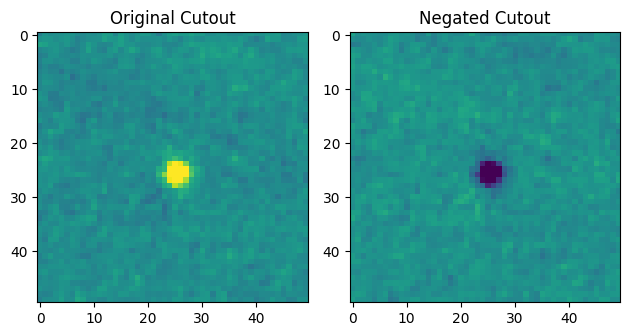

neg_flux_min: 0.5598928928375244
pos_flux: 195.33010864257812 nJy, neg_flux: 7.974418640136719 nJy
flux diff: 187.35568237304688 nJy, flux threshold: 78.13204193115234 nJy
not dipole
RA: 150.02713512565222 DEC: 2.41342047414368


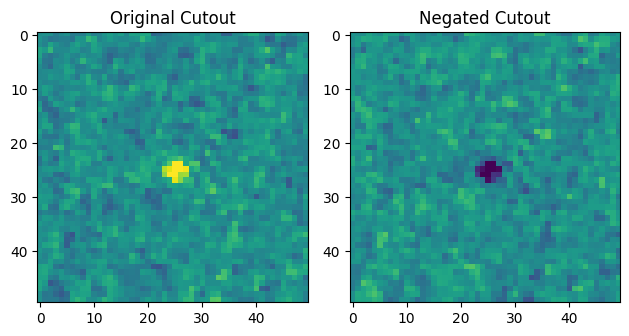

neg_flux_min: 0.37555840611457825
pos_flux: 90.9836654663086 nJy, neg_flux: 12.27125358581543 nJy
flux diff: 78.71240997314453 nJy, flux threshold: 36.39346694946289 nJy
not dipole
RA: 150.04005226926688 DEC: 2.472896135825602


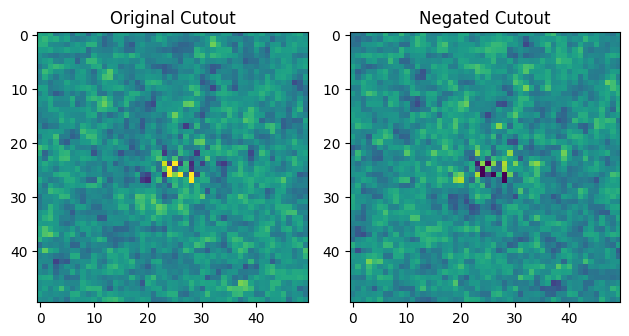

neg_flux_min: 0.20438125729560852
pos_flux: 12.863717079162598 nJy, neg_flux: 6.276059627532959 nJy
flux diff: 6.587657451629639 nJy, flux threshold: 5.145486831665039 nJy
not dipole
RA: 150.04116228177276 DEC: 2.4886411618746602


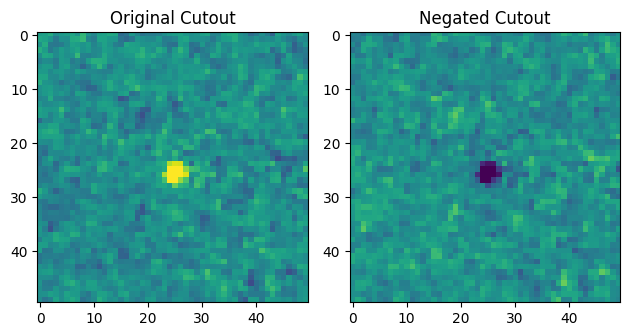

neg_flux_min: 0.29599127173423767
pos_flux: 77.53907775878906 nJy, neg_flux: 10.031132698059082 nJy
flux diff: 67.50794219970703 nJy, flux threshold: 31.0156307220459 nJy
not dipole
RA: 150.04921328513444 DEC: 2.5219918918078084


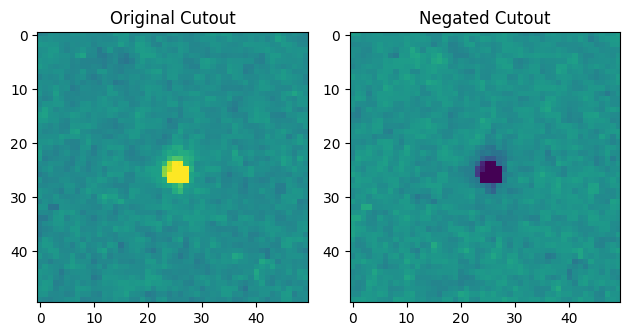

not dipole
RA: 150.05748007438507 DEC: 2.5134891020368593


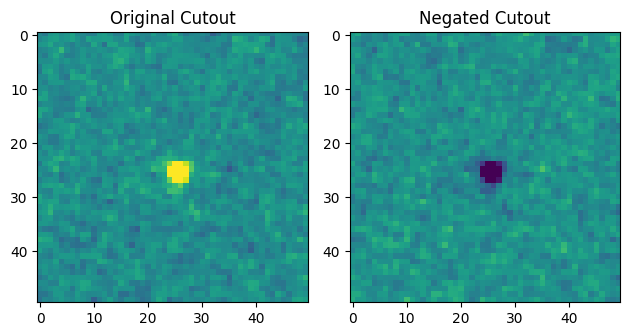

neg_flux_min: 0.35946184396743774
pos_flux: 112.9945297241211 nJy, neg_flux: 7.777682304382324 nJy
flux diff: 105.21685028076172 nJy, flux threshold: 45.197811126708984 nJy
not dipole
RA: 150.0578753867169 DEC: 2.4008086055272893


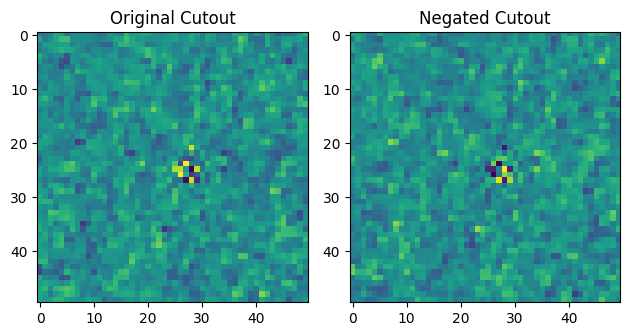

neg_flux_min: 0.28987300395965576
pos_flux: 6.964031219482422 nJy, neg_flux: 8.686965942382812 nJy
flux diff: -1.7229347229003906 nJy, flux threshold: 2.7856125831604004 nJy
dipole
RA: 150.06595686095355 DEC: 2.516833344241462


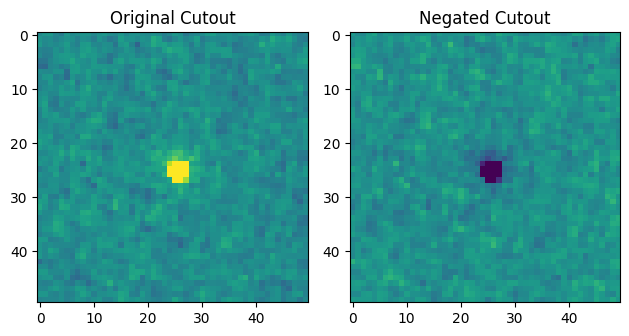

neg_flux_min: 0.41688215732574463
pos_flux: 138.78549194335938 nJy, neg_flux: 5.191131114959717 nJy
flux diff: 133.5943603515625 nJy, flux threshold: 55.514198303222656 nJy
not dipole
RA: 150.10279609324314 DEC: 2.3826189710403805


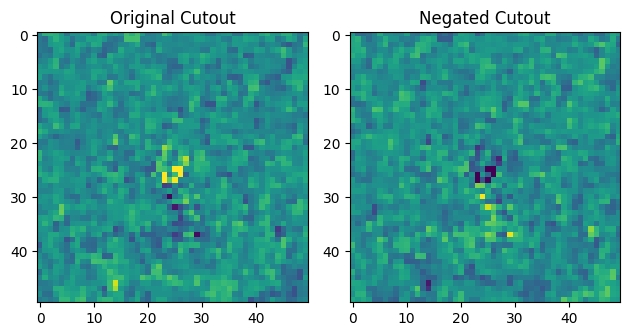

neg_flux_min: 0.2644163966178894
pos_flux: 19.602285385131836 nJy, neg_flux: 11.79980754852295 nJy
flux diff: 7.802477836608887 nJy, flux threshold: 7.840914249420166 nJy
dipole
RA: 150.10873501472133 DEC: 2.4188592119192656


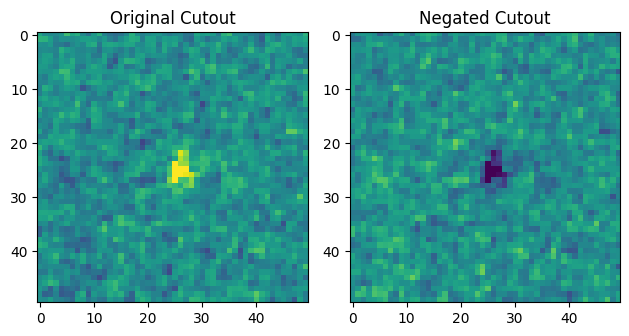

neg_flux_min: 0.23261648416519165
pos_flux: 48.07598876953125 nJy, neg_flux: 5.529768466949463 nJy
flux diff: 42.54621887207031 nJy, flux threshold: 19.230396270751953 nJy
not dipole
RA: 150.1171934026161 DEC: 2.376453428269433


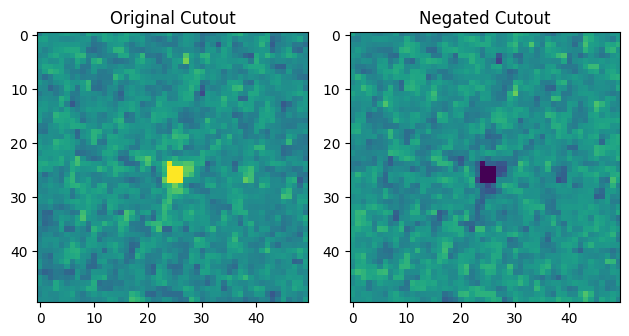

neg_flux_min: 0.3500237464904785
pos_flux: 91.54288482666016 nJy, neg_flux: 3.691629409790039 nJy
flux diff: 87.85125732421875 nJy, flux threshold: 36.61715316772461 nJy
not dipole
RA: 150.11811001720324 DEC: 2.3828997982403415


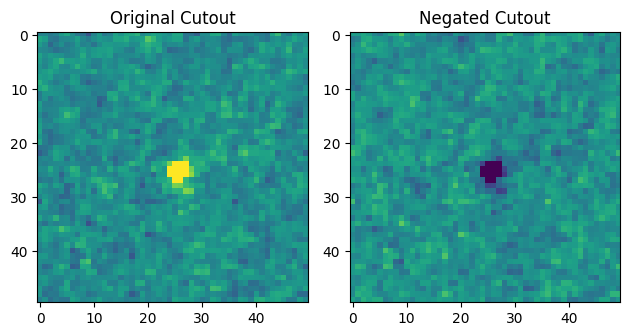

neg_flux_min: 0.21583157777786255
pos_flux: 57.927955627441406 nJy, neg_flux: 3.2776033878326416 nJy
flux diff: 54.650352478027344 nJy, flux threshold: 23.17118263244629 nJy
not dipole
RA: 150.13451434071752 DEC: 2.3724814153192195


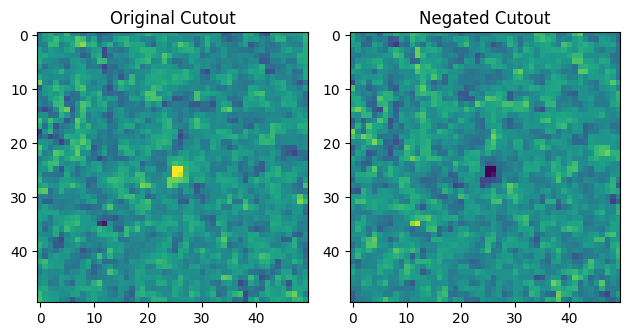

neg_flux_min: 0.2628540098667145
pos_flux: 24.81937599182129 nJy, neg_flux: 14.956713676452637 nJy
flux diff: 9.862662315368652 nJy, flux threshold: 9.927750587463379 nJy
dipole
RA: 150.13883609064143 DEC: 2.478032437941443


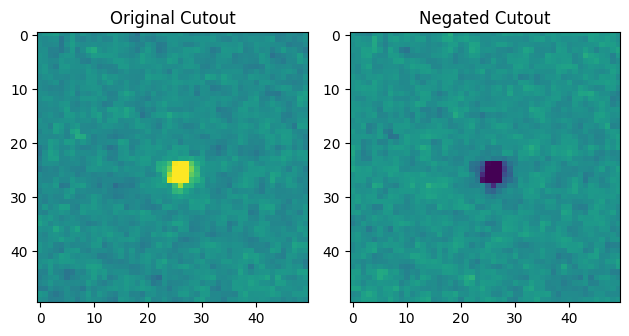

neg_flux_min: 0.48965319991111755
pos_flux: 171.96388244628906 nJy, neg_flux: 5.284553527832031 nJy
flux diff: 166.6793212890625 nJy, flux threshold: 68.78555297851562 nJy
not dipole
RA: 150.14438304386803 DEC: 2.4159848453262107


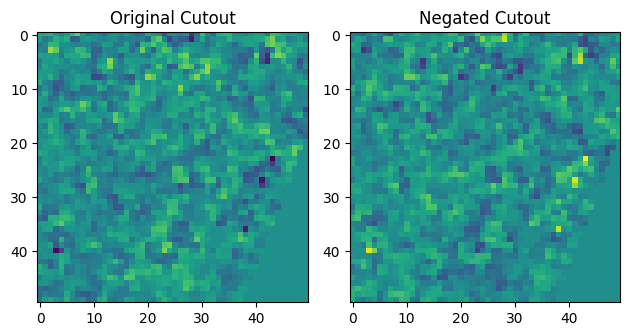

neg_flux_min: 0.26422834396362305
pos_flux: 10.507566452026367 nJy, neg_flux: 9.156657218933105 nJy
flux diff: 1.3509092330932617 nJy, flux threshold: 4.20302677154541 nJy
dipole
RA: 150.15196663933688 DEC: 2.3956486883432437


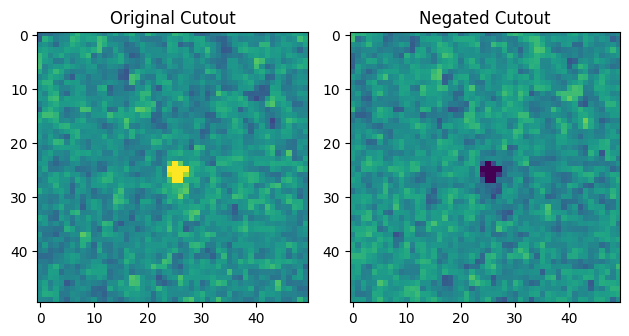

neg_flux_min: 0.16584962606430054
pos_flux: 36.93189239501953 nJy, neg_flux: 3.0006802082061768 nJy
flux diff: 33.93121337890625 nJy, flux threshold: 14.772757530212402 nJy
not dipole
RA: 150.15255411723317 DEC: 2.4923697425651854


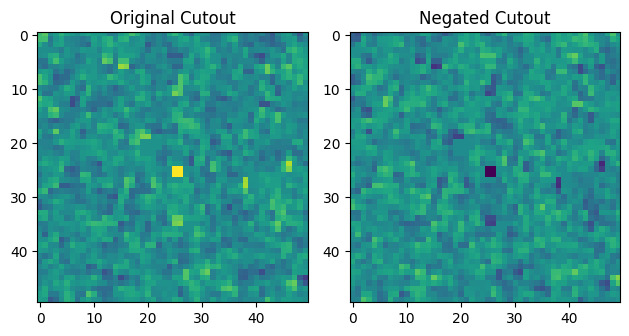

neg_flux_min: 0.2884671688079834
pos_flux: 25.675968170166016 nJy, neg_flux: 11.512798309326172 nJy
flux diff: 14.163169860839844 nJy, flux threshold: 10.270387649536133 nJy
not dipole
RA: 150.15645712112422 DEC: 2.408014198779508


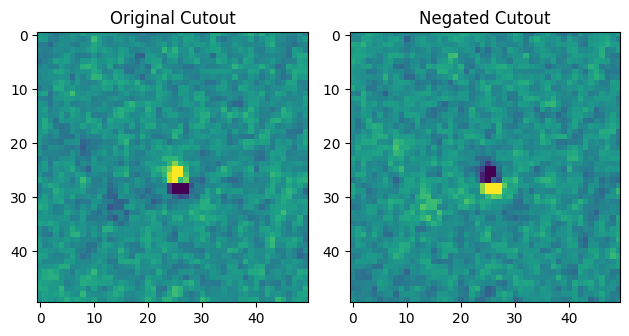

neg_flux_min: 0.24186939001083374
pos_flux: 25.67218017578125 nJy, neg_flux: 31.5653133392334 nJy
flux diff: -5.893133163452148 nJy, flux threshold: 10.268872261047363 nJy
dipole
RA: 150.15908120985023 DEC: 2.4783860336135985


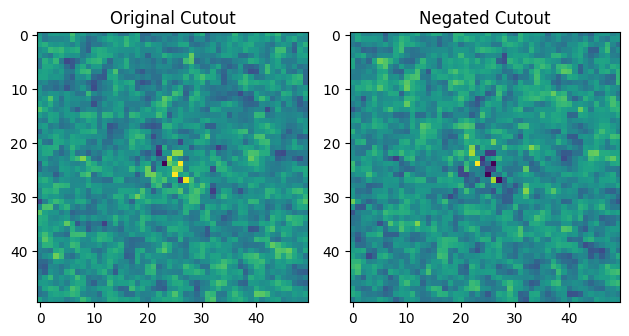

neg_flux_min: 0.1877070814371109
pos_flux: 9.983541488647461 nJy, neg_flux: 7.4180121421813965 nJy
flux diff: 2.5655293464660645 nJy, flux threshold: 3.9934165477752686 nJy
dipole
RA: 150.16612471833486 DEC: 2.471441956649688


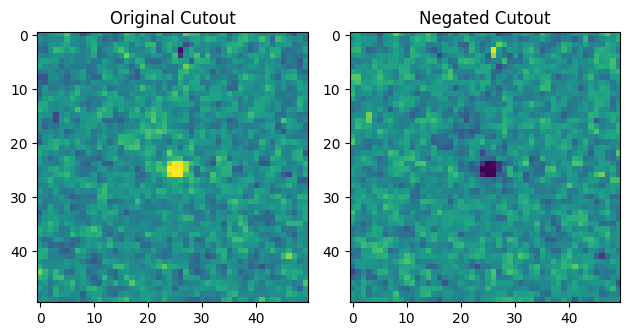

neg_flux_min: 0.19064417481422424
pos_flux: 34.86004638671875 nJy, neg_flux: 3.888906240463257 nJy
flux diff: 30.971139907836914 nJy, flux threshold: 13.944018363952637 nJy
not dipole


In [69]:
#Check that dipoles are removed:
plot_non_dipoles(removed_dipoles=removed_dipoles , data=data, header=header)
#plot_dipoles(removed_dipoles=dipoles , data=data, header=header)

In [70]:
from astropy.wcs import WCS
def convert_to_skycoord(header, coords):
    sky_coords = []
    for coord in coords:
        x, y = coord
        w = WCS(header)
        ra_dec = w.pixel_to_world(x, y)
        sky_coords.append(ra_dec)
    return sky_coords

skycoords_no_dipoles = convert_to_skycoord(header[2], removed_dipoles)

In [71]:
from python_files.Plot_all_filters import find_diff_bands_cutout_plot

In [72]:
#find_diff_bands_cutout_plot(path_to_data[-5:], data, header, skycoords_no_dipoles)

In [73]:
mag_no_dipoles = magnitude_in_each_band_with_aperture(skycoords_no_dipoles, data, header)

In [74]:
from astropy.io import fits

with fits.open('C:/Users/andre/MasterCode/CosmosWebCatalogue/COSMOSWeb_master_v3.1.0-sersic-cgs_err-calib_LePhare.fits') as hdul:

    table = hdul[1].data
    header0 = hdul[0].header 
    header1 = hdul[1].header

rows = []
cosmos_RA = []
cosmos_DEC = []

for row in table:          # iterate directly over the items in `table`
    rows.append(row)       # save the row
    cosmos_RA.append(row['RA_DETEC'])
    cosmos_DEC.append(row['DEC_DETEC'])

In [75]:
float_skycoords_no_dipoles= [(float(x.ra.deg),float(x.dec.deg)) for x in skycoords_no_dipoles] 

In [76]:
from python_files.Find_closest_object import find_closest_objects_kdtree

obj, dist, z_final, z_PDF, z_u68, z_l68 = find_closest_objects_kdtree(rows, cosmos_RA, cosmos_DEC, float_skycoords_no_dipoles)


In [77]:
import csv
import os

# Create a folder to store csv file
output_folder_csvfile = 'C:/Users/andre/MasterCode/Code/cross_matched_transients/all_transformations/'
os.makedirs(output_folder_csvfile, exist_ok=True)  # Creates the folder if it doesn't exist

csv_file_name = os.path.join(output_folder_csvfile, path_to_data[-5:]+'.csv')

with open(csv_file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'RA', 'DEC', 'x', 'y', 'CNN_prediction', 'F115W_old', 'F115W_new', 'F115W_diff', 'F150W', 'F200W', 'F277W', 'F356W', 'F444W', 'COSMOS-Web Catalog ID', 'Distance to host (in arcsec)', 'z_Final', 'z_PDF', 'z_u68', 'zl68'])

    for i in range(len(skycoords_no_dipoles)):
        sky = skycoords_no_dipoles[i]
        x, y = removed_dipoles[i]
        mag = mag_no_dipoles[i]
        ob = obj[i]
        dis = dist[i]
        z_fin = z_final[i]
        z = z_PDF[i]
        z_u = z_u68[i]
        z_l = z_l68[i]
        writer.writerow([
            f'{path_to_data[-5:]}_{i}', sky.ra.deg, sky.dec.deg, f'{x:.4f}', f'{y:.4f}', 1,
            f'{mag[0]:.4f}', f'{mag[1]:.4f}', f'{mag[2]:.4f}', f'{mag[3]:.4f}',
            f'{mag[4]:.4f}', f'{mag[5]:.4f}', f'{mag[6]:.4f}', f'{mag[7]:.4f}',
            f'{ob}', f'{dis}', f'{z_fin}', f'{z}', f'{z_u}', f'{z_l}' 
        ])